# Predicting the probability of churn customers from fitness center

## Structure

1. [Описание проекта](#description)
2. [Загрузка данных](#start)
3. [Исследовательский анализ данных (EDA)](#eda)
    * [Средние значения и стандартные отклонения](#means)
    * [Средние значения признаков в группах оттока](#means_churn)
    * [Гистограммы](#hist)
    * [Матрица корреляций](#corr)
    * [](#conclusion_eda)
4. [Модель прогнозирования оттока клиентов](#pred_model)
    * [Обучающая и валидационная выборки](#train_test_samples)
    * [Логистическая регрессия](#logic_reg)
    * [Случайный лес](#random_forest)
    * [Метрики](#metrics_pred)
    * [Вывод](#conclusion_pred_model)
5. [Кластеризация клиентов](#cluster)
    * [Стандартизация данных](#standardization)
    * [Матрица расстояний](#linkage)
    * [Модель кластеризации (алгоритм K-Means)](#k_means)
    * [Средние значения признаков для кластеров](#clust_means)
    * [Графики распределения признаков](#graph_clust)
    * [Доля оттока у каждого кластера](#churn_cluster)
    * [Вывод](#conclusion_cluster)
6. [Выводы и базовые рекомендации по работе с клиентами](#conclusion)

<a id="start"></a>
## Importing libraries and dataset

Importing the necessary libraries for further work

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Download the provided data, convert it to a `DataFrame` using `pandas`. We will output information about the dataset and its first 5 rows.

In total we have 4000 rows and 14 columns. There are no missing values.

In [2]:
df = pd.read_csv('gym_churn.csv')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Download the provided data, convert it to a `DataFrame` using `pandas`. We will output information about the dataset and its first 5 lines.

In total we have 4000 rows and 14 columns. There are no missing values.

In [3]:
# we will reduce all column names to lowercase
df.columns = [i.lower() for i in df.columns]

### Summary
We read the `csv`, learned the attributes of the dataset, edited the column names, and also described the data. Next, we will conduct a exploratory data analysis

<a id="eda"></a>
## EDA

Let's examine whether there are missing signs and duplicates in the dataset

Duplicates and missing values were not found

In [4]:
pd.isna(df).sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [5]:
df.duplicated().sum()

0

<a id="means"></a>
### Means and standard deviations
We will output the average values and standard deviations

In the dataset, most of the columns are encoded binary (1-yes, 0-no), so `mean` shows a fraction of "yes". 

You can also see that the average age ranges from 26 to 32 years. In the current month, the average number of visits is about 1, and for the entire time 147 (± 96) visits.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Portrait of a typical client**:
1. Lives near the gym
2. Membership for 4 months
3. From 26 to 32 years old
4. He has been going to the gym for 3 months
5. On average visits the gym 1 time a month

<a id="means_churn"></a>
### Average values of characteristics in churn groups
Let's look at the average values of the signs in two groups — those who went into the outflow and those who stayed

Among those who is churn, and there are 1061 clients, the indicators for "bring a friend" are lower. The average number of visits in total and in the last month is 1-2.

Those who stayed are more often employees of partner companies. On average, they have 43 more visits than those who went into the outflow. Also, on average, the duration of the current subscription is six months against a month for those who are in outflow.

In [7]:
# описательные характеристики среди тех, кто ушел в отток
df_churn = df[df['churn']==1]
df_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


In [8]:
# описательные характеристики среди тех, кто остался
df_stay = df[df['churn']==0]
df_stay.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


<a id="hist"></a>
### Histograms
Let's build columnar histograms and distributions of signs for those who left (churn=1) and those who stayed (churn=0)

According to histograms and density graphs, we see that the age is distributed in both groups close to normal. The indicators of average attendance and lifetime are skewed to the left. This means that in the future we will need to standardize and normalize the features.

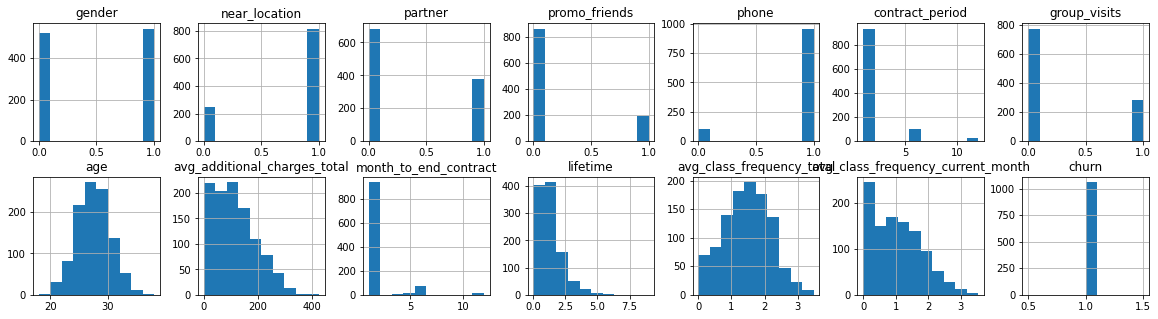

In [9]:
%matplotlib inline

fig, axis = plt.subplots(2,7,figsize=(20, 5))
df_churn.hist(ax=axis)
plt.show()

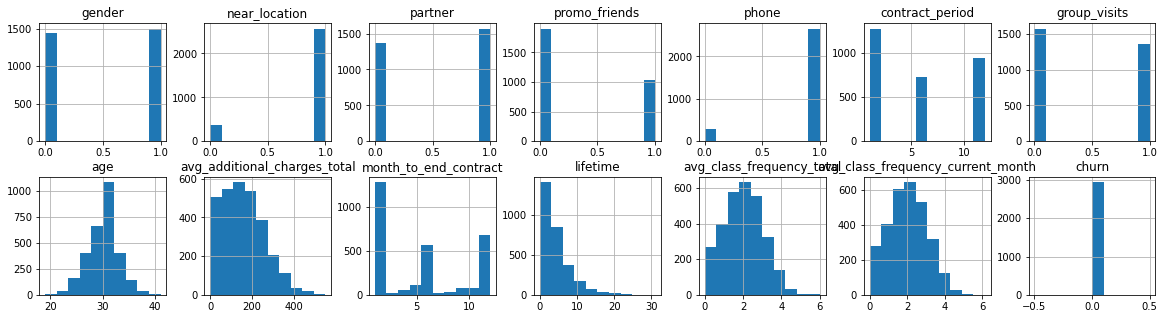

In [10]:
fig, axis = plt.subplots(2,7,figsize=(20, 5))
df_stay.hist(ax=axis)
plt.show()

In [11]:
def displots(df):    
    for col in df.columns:
        plt.rcParams['figure.figsize']=5,5
        data = df[col]
        sns.kdeplot(data)
        plt.show()

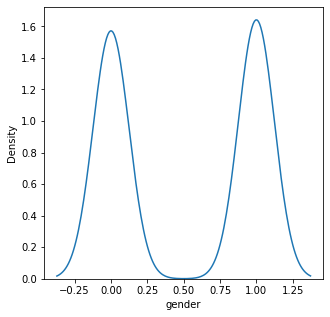

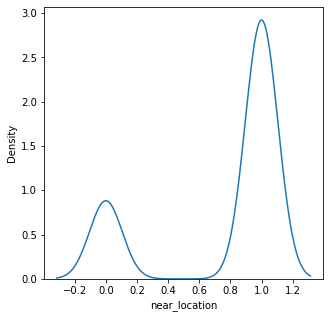

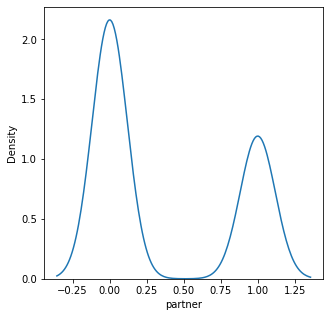

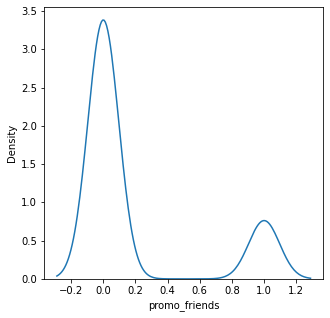

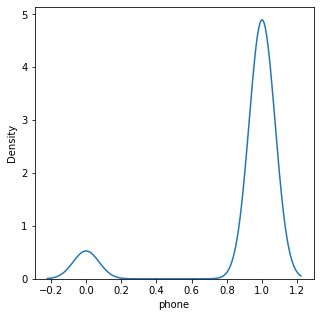

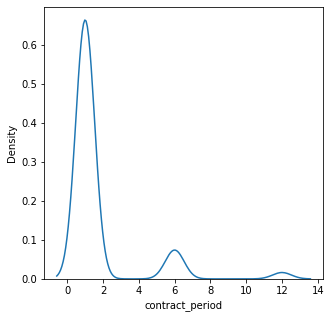

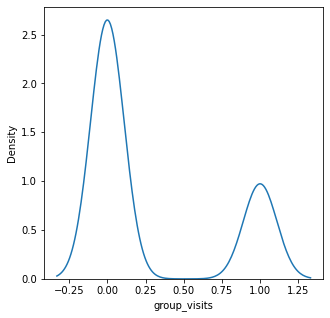

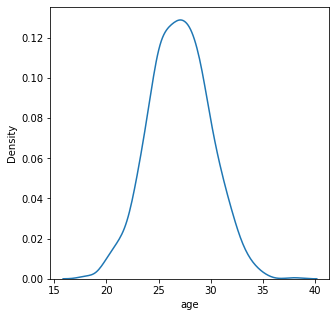

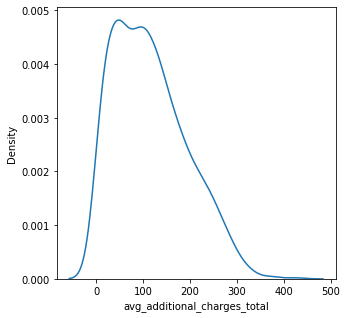

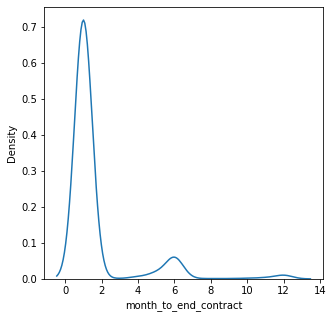

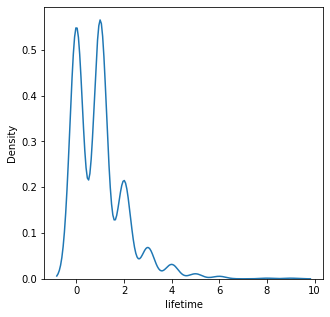

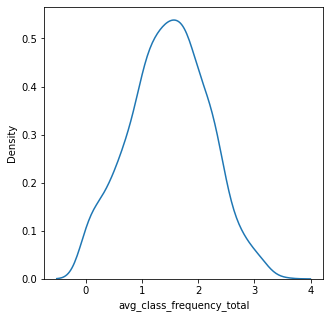

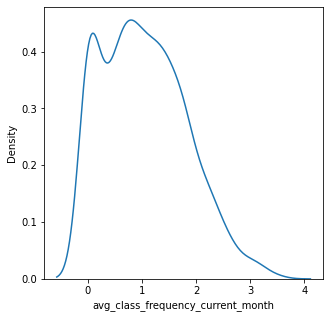

In [12]:
displots(df_churn.drop('churn', axis=1))

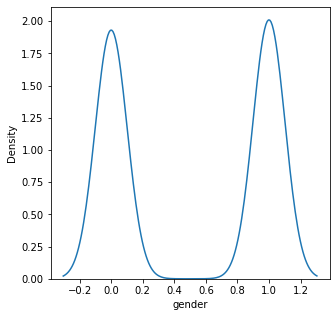

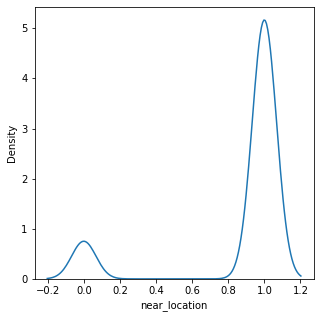

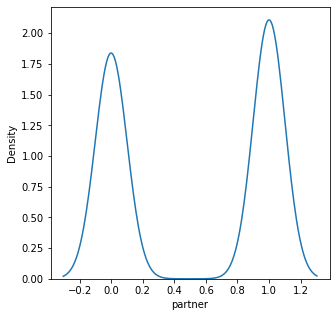

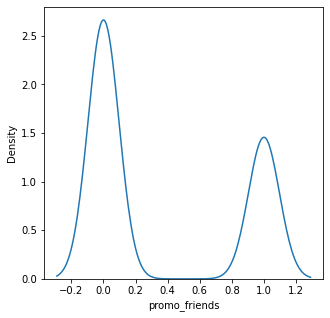

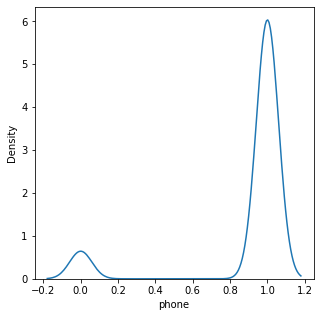

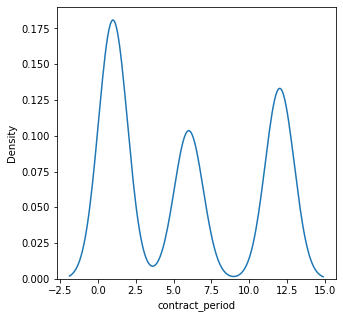

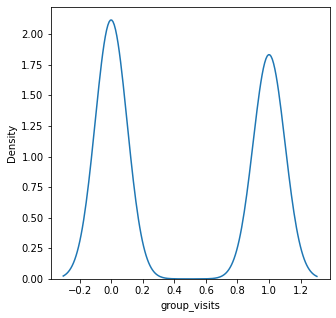

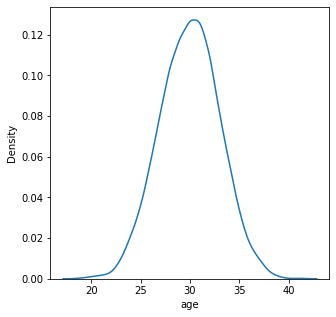

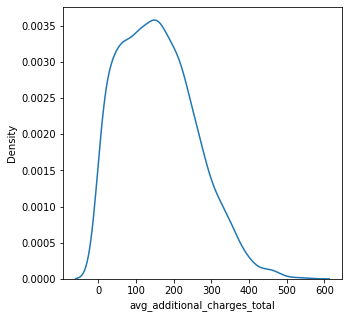

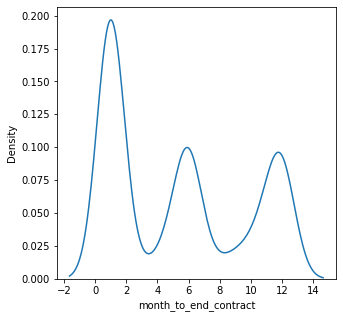

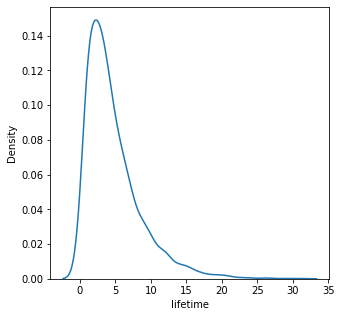

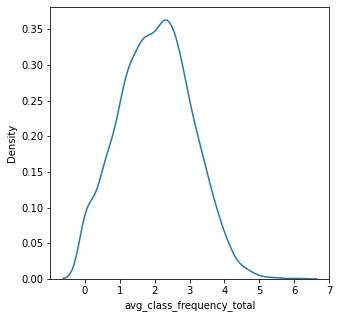

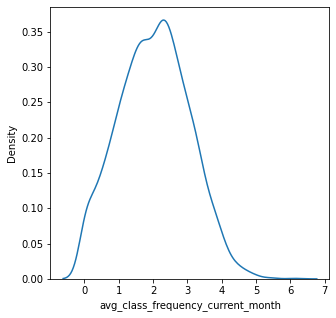

In [13]:
displots(df_stay.drop('churn', axis=1))

<a id="corr"></a>
### Correlation matrix
Let's build a correlation matrix

According to the graph, we see that there are no strong correlations that could further interfere with the construction of the model. The "strongest" among correlations is 0.45 between the signs `promo_friends` and `partner`. However, there is a multicollinearity between the two pairs of signs — `contract_period` and `month_to_end_contract` (it was decided to remove the second one), `avg_class_frequency_total` and `avg_class_frequency_current_month` (it was decided to leave it, since the number of visits in the current month may differ greatly from the total)

Also, the hitman shows which signs correlate more strongly with `churn` than others, then we will examine them in more detail.

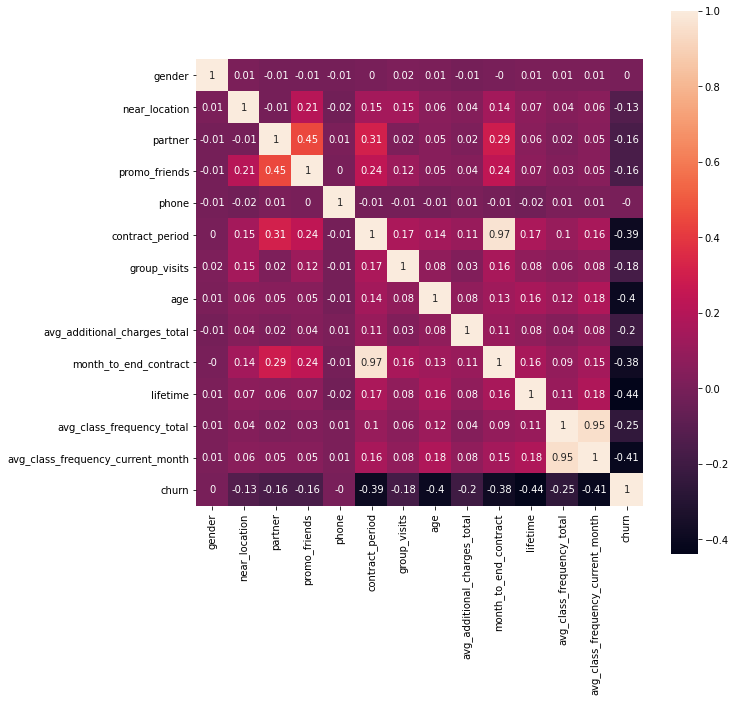

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(round(df.corr(),2), annot=True, square=True)
plt.show()

In [15]:
df = df.drop('month_to_end_contract', axis=1)

<a id="sum_eda"></a>
### Summary
We examined the data before building the model, came to the conclusion that there are no strong relationships between the features (there will be no multicollinearity problem). We also came to the conclusion that it will be necessary to standardize the data for clustering.

<a id="pred_model"></a>
## Customer churn prediction model
Let's build a model of binary classification of clients, where the target attribute is the fact of client churn in the next month

<a id="train_test_samples"></a>
### Train and test samples
Let's split the data into a training and validation sample

In [16]:
X = df.drop('churn', axis=1)
y = df['churn']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

<a id="logic_reg"></a>
### Logistic regression
Let's train the model on a train sample by logistic regression

In [18]:
# standardization
scaler = StandardScaler().fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [19]:
model_logic = LogisticRegression(solver='liblinear')
model_logic.fit(X_train_st, y_train)

predictions_logic = model_logic.predict(X_test_st)
probabilities_logic = model_logic.predict_proba(X_test_st)[:,1]

<a id="random_forest"></a>
### Random forest
Let's train the model on a train sample with a random forest

In [20]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

<a id="metrics_pred"></a>
### Metrics
Let's evaluate the metrics `accuracy`, `precision` and `recall` for both models on the validation sample. 

Let's compare the models according to them. 

*Which model performed better based on metrics?* According to metrics, the **logistic regression** model performed better.

In [21]:
def print_all_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [22]:
print_all_metrics(y_test, predictions_logic, title='Metrics for logical regression')

Метрики для модели логистической регресии
	Accuracy: 0.93
	Precision: 0.88
	Recall: 0.83


In [23]:
print_all_metrics(y_test, rf_predictions, title='Metrics for random forest model')

Метрики для модели логистической регресии
	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.81


<a id="sum_pred_model"></a>
### Summary
We have trained two models: logistic regression and random forest, the first one fits our data better by metrics

<a id="cluster"></a>
## Customer Clustering

<a id="standardization"></a>
### Data standardization

In [24]:
df_clust = df.drop('churn', axis=1)

In [25]:
sc = StandardScaler()
X_sc = sc.fit_transform(df_clust)

<a id="linkage"></a>
### Linkage clustering
Let's build a distance matrix on a standardized feature matrix and draw a dendrogram.

Based on the resulting graph, it can be assumed that 4 clusters (4 colors) can be distinguished

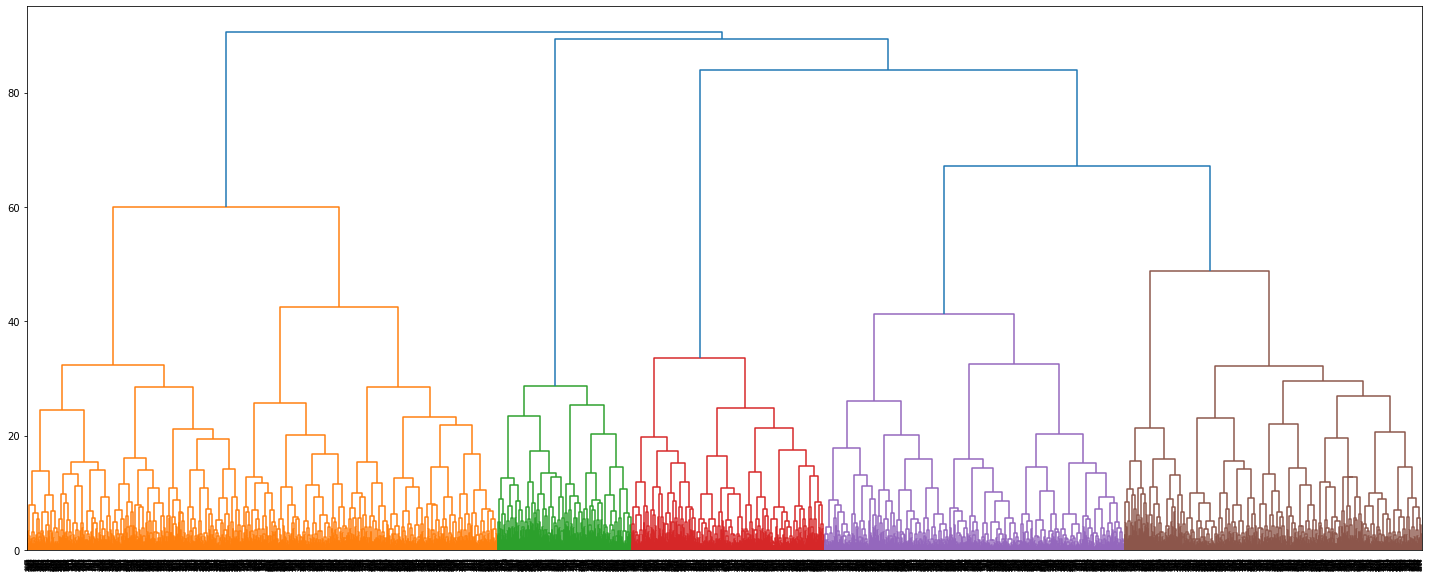

In [26]:
Z = linkage(X_sc, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

<a id="k_means"></a>
### K-Means
Let's train a clustering model based on the K-Means algorithm and predict client clusters

The largest cluster is the fourth, the smallest in the third cluster

In [27]:
km = KMeans(n_clusters=5, random_state=0)

labels = km.fit_predict(X_sc)
df['cluster_km'] = labels

df['cluster_km'].value_counts()

2    1185
0     995
3     902
4     533
1     385
Name: cluster_km, dtype: int64

<a id="clust_means"></a>
### Average values of characteristics for clusters

Let's look at the average values of features for clusters

For example, in the **second cluster**, less than 1% of customers used the "bring a friend" promotion at the initial registration and all do not live near the gym. The ** first cluster** includes customers who go to this gym the longest, and who, on average, go to the gym more often than others. In **the fourth cluster** customers who do not have a phone number specified. In **The third cluster**, almost all clients are employees of the club's partner companies. **The fifth cluster** differs in that it has the lowest average number of visits in gym.

In [28]:
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,
0,0.478392,0.993970,0.947739,0.879397,1.000000,7.831156,0.536683,29.629146,154.788356,4.447236,1.836547,1.795608,0.102513
1,0.524675,0.862338,0.472727,0.306494,0.000000,4.758442,0.425974,29.283117,144.240418,3.922078,1.846575,1.716160,0.267532
2,0.494515,1.000000,0.240506,0.095359,1.000000,2.483544,0.331646,28.216034,131.341969,2.440506,1.255953,1.030234,0.502110
3,0.568736,0.970067,0.307095,0.097561,0.998891,5.137472,0.483370,30.288248,166.180576,5.011086,2.879208,2.882946,0.041020
4,0.495310,0.000000,0.487805,0.075047,1.000000,2.859287,0.228893,28.566604,136.384285,2.911820,1.674358,1.500208,0.420263


<a id="graph_clust"></a>
### Graphs of the distribution of characteristics

In [29]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(12, 4))
    sns.scatterplot(x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired')
    plt.title(f'{x_name} vs {y_name}')
    plt.show()

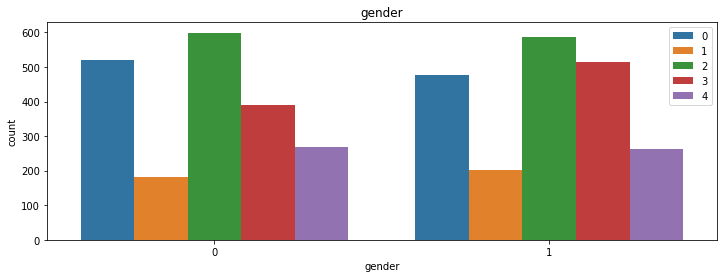

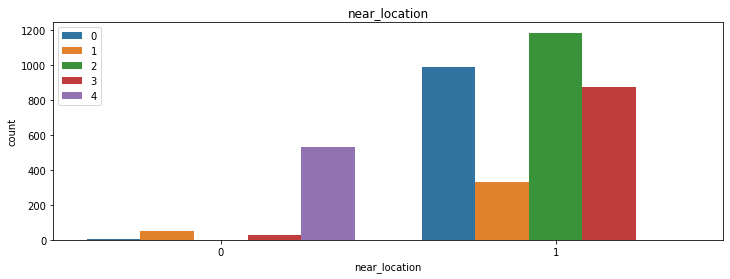

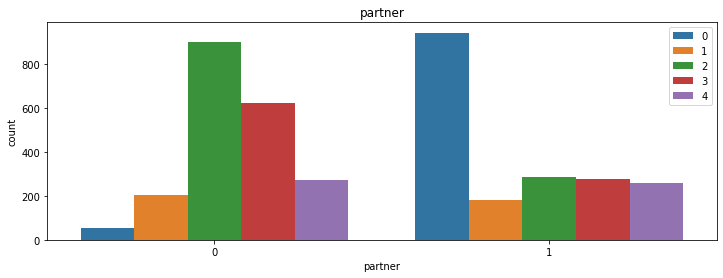

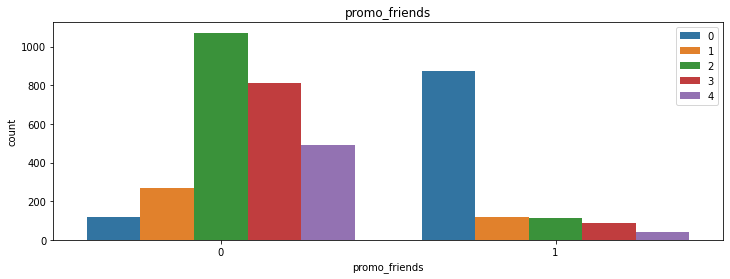

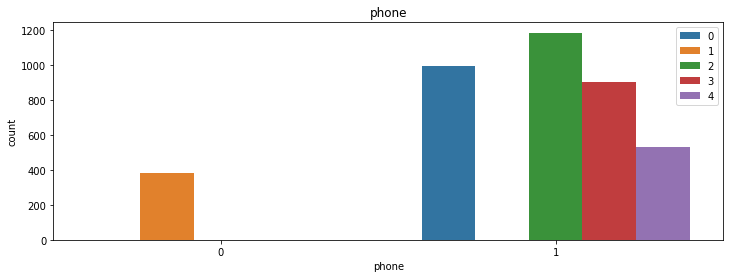

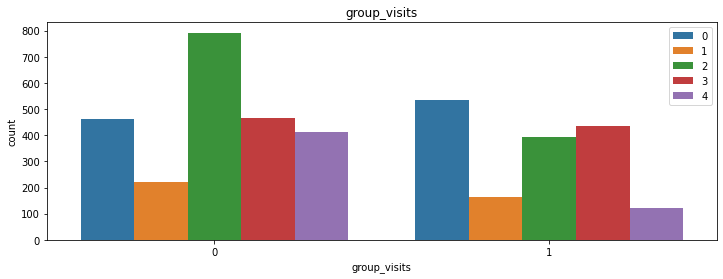

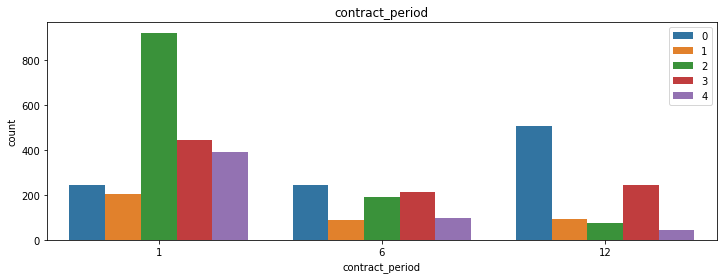

In [30]:
categorical_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period']

for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=df[column], hue="cluster_km", data=df)
    plt.title(column)
    plt.legend()
    plt.show()

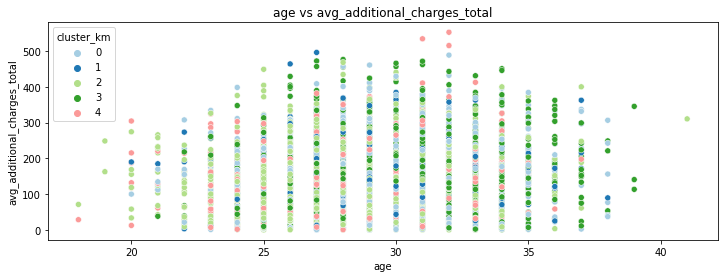

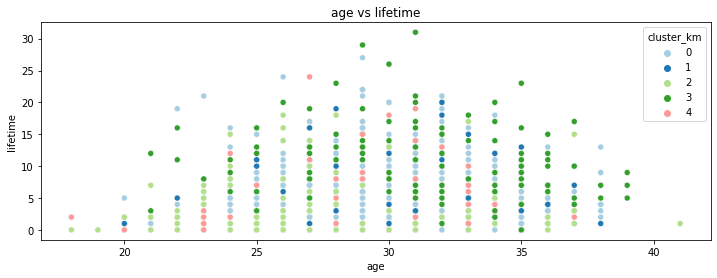

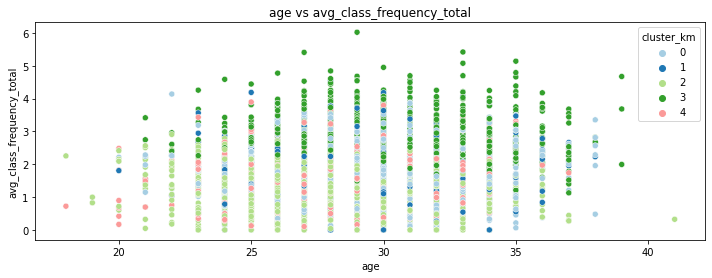

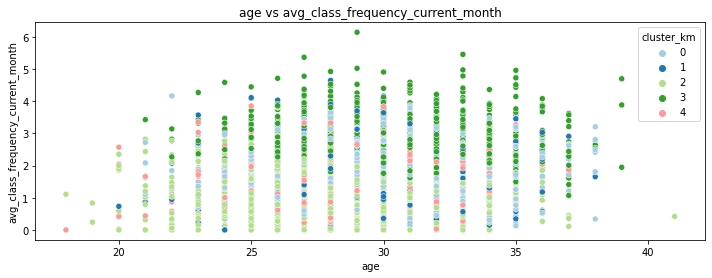

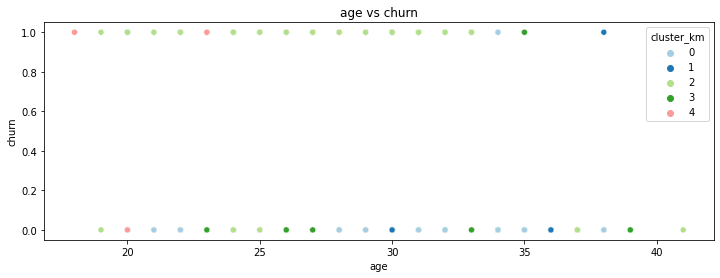

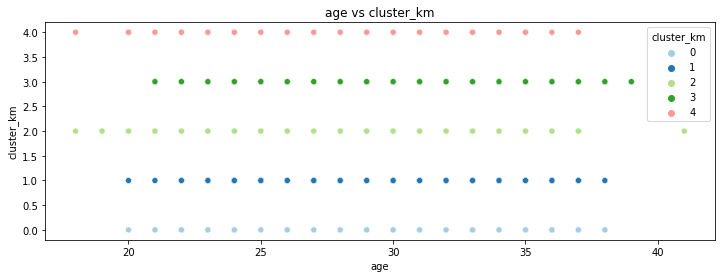

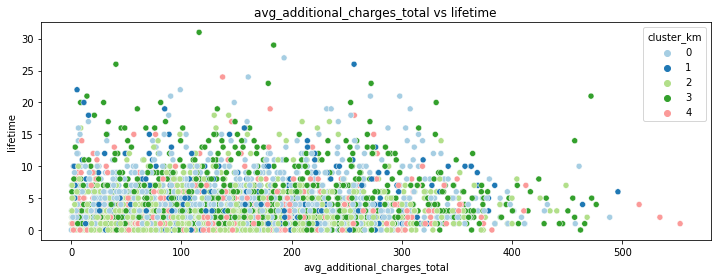

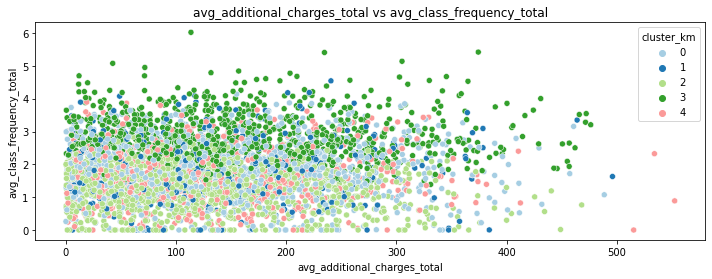

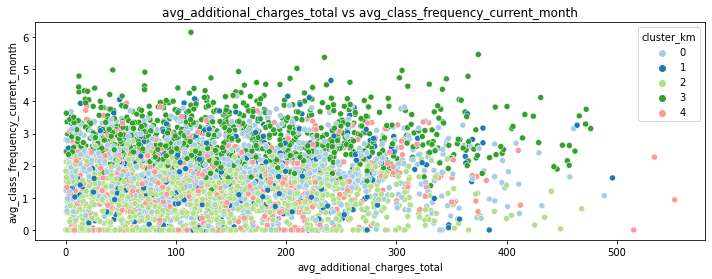

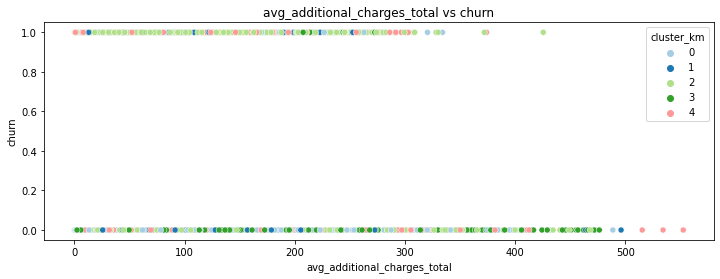

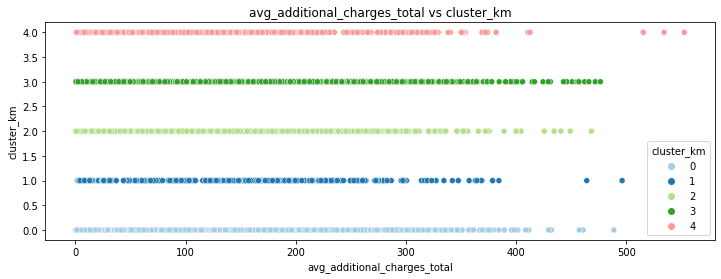

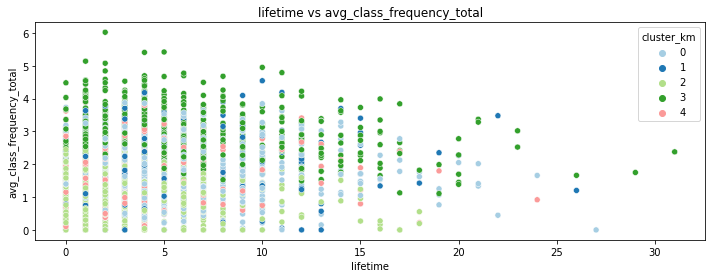

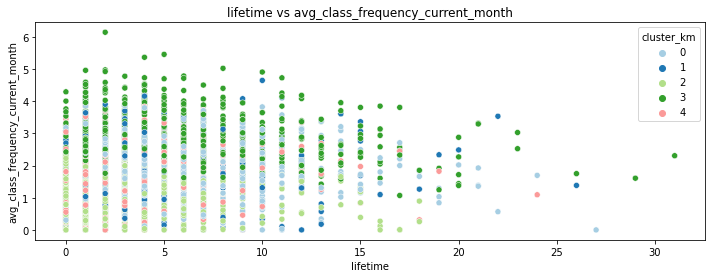

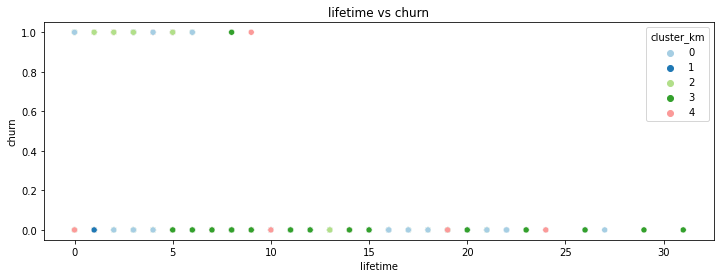

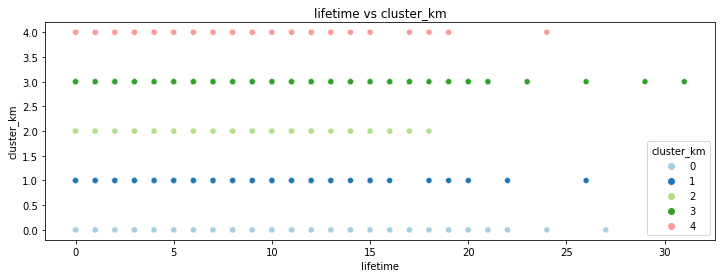

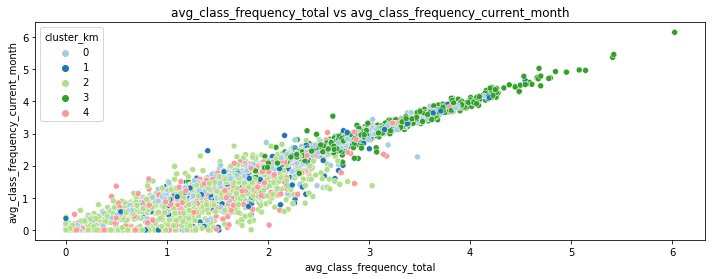

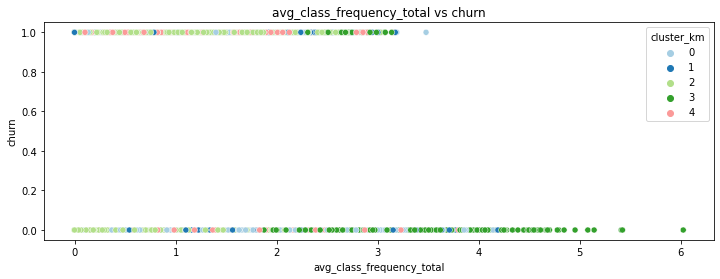

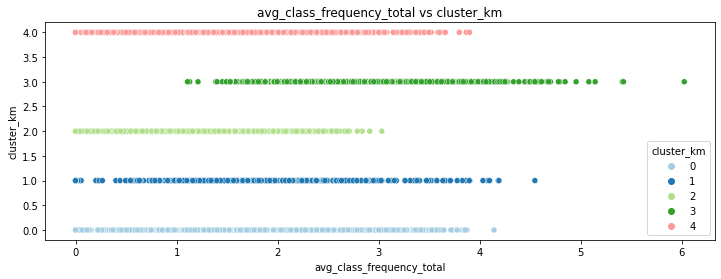

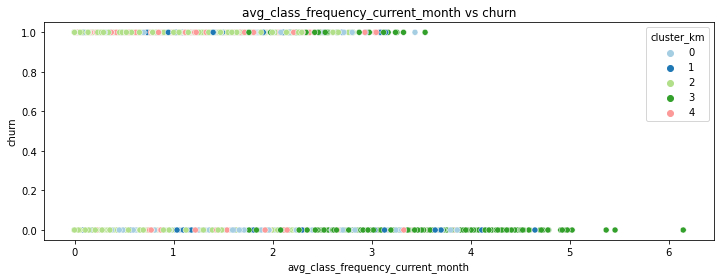

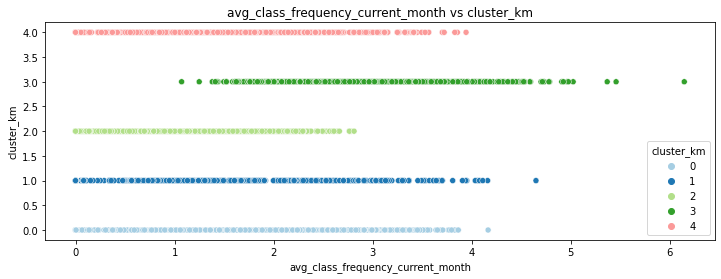

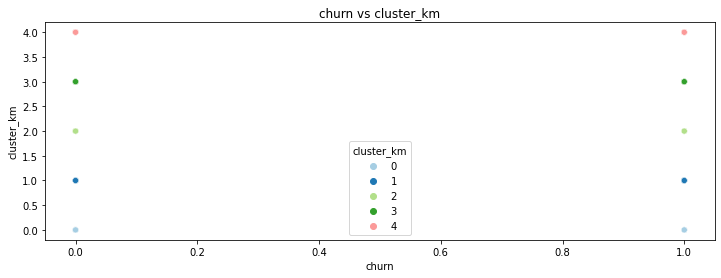

In [31]:
df_cont = df.drop(categorical_columns, axis=1)

col_pairs = list(itertools.combinations(df_cont.columns, 2))

for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_km')

<a id="churn_cluster"></a>
### The churn share of each cluster
For each received cluster, we will calculate the churn share. 

* Do they differ in the share of outflow?*
Yes and strongly

* Which clusters are prone to outflow, and which are reliable? *
The fifth and second clusters are more prone to churn. The first and third clusters are more reliable.

In [32]:
df.groupby('cluster_km')['churn'].mean()

cluster_km
0    0.102513
1    0.267532
2    0.502110
3    0.041020
4    0.420263
Name: churn, dtype: float64

<a id="sum_cluster"></a>
### Summary
We divided the clients into 5 clusters, displayed the difference between them in the form of tables and graphs. We examined how each cluster differs in outflow - the second cluster is the most reliable, the third cluster is more prone to churn.

The third cluster has almost all clients employees of partner companies. They have the longest subscriptions and most of them live near the gym.

About the fourth cluster, we can say that no client has a phone number specified.

<a id="conclusion"></a>
##  Conclusion and recommendations

The conclusion and recommendations for the strategy of interaction with customers and their retention.

We have analyzed the data and can make some recommendations based on the findings

> there are 5 clusters among clients: the second one is the most reliable. Reliability indicators can be considered the duration of his subscription, whether he used the "bring a friend" service during the initial registration, as well as whether he is an employee of the partner company of gym. It is also worth paying attention to this cluster, as well as increasing the number of partner companies and the scale of advertising the "bring a friend" campaign to increase the number of customers in this cluster

> it is worth paying more attention to the third cluster, as it is most prone to churn. It can be determined by such signs as living near the gym, low attendance rates, as well as the age of 26-27, who go to the gym for no more than 2 months. Such clients can increase the number of offers through advertising when their lifetime is closer to 2 months. You can also recommend offering profitable promotions for the purchase of longer season tickets.

> in general, you should pay attention to such signs as the age of the client, the younger the client, the longer the subscription can be advertised / offered to him. It is worth paying attention to group classes, since among all clusters there were low indicators of this trait.

> in this case, the logistic regression model is suitable for predicting outflow for the future, as the metrics have shown.